   <font color=black size=5 face=雅黑>**项目：分析AB测结果（确定网站翻译版本）**</font>

<font color=black size=4 face=雅黑>**1.项目介绍**</font>

公司XYZ是一家有本地化网站的全球电子商务公司。公司XYZ的一位数据科学家注意到，西班牙语国家用户的转换率比其他国家（非西班牙语）都要高得多。

西班牙和拉丁美洲国家（也是说西班牙语）的管理者们表示，其中一个原因可能是翻译。因为所有西班牙语国家都使用相同的翻译版本的网站，该网站是由西班牙人翻译的。因此他们同意尝试一个测试，让每个西班牙语国家都用自己本地人翻译的网站。也就是说，阿根廷用户使用阿根廷人翻译的网站，墨西哥用户使用墨西哥人翻译的网站，以此类推。显然，对于来自西班牙的用户来说，什么都不会改变，还是使用西班牙人翻译的旧网站。

然而，在他们进行测试后，他们真的很惊讶，因为测试结果是negative的。也就是说，似乎非高度本地化翻译的网站做得更好!

**<font color = black size=4 face=雅黑>2.项目要解决的问题</font>**：

1. 确认测试结果是negative的，也就是说，该网站的旧版本也就是用西班牙人翻译的网站-非高度本地化的翻译，表现更好。

2. 解释为什么会发生这种情况。本地化翻译的网站真的很糟糕吗?

3. 如果你发现了错误所在，设计一个算法，如果同样的问题在未来再次发生，该算法将返回FALSE，如果一切正常且结果可信，该算法将返回TRUE。

<font color=black size=4 face=雅黑>**3.项目用到的两个数据集：test_table和user_table**</font>

test_table: 关于实验结果
* user_id
* date
* source
* device
* browser_language
* ads_channel
* conversion : 标签。用户是否转换。转化(1),未转换(0）
实验成功：当用户转换率的比例提高了。
* test: 实验组(1), 控制组(0). 实验组用户使用高度本地化网站，控制组用户使用旧版本。对于西班牙用户标记为0，因为没有改变。

user_table: 关于用户信息
* user_id
* sex
* age
* country: 用户地区基于IP地址

<font color=black size=4 face=雅黑>**4.项目关键点：A/B test 关键点**</font>

A/B测试背后的一个关键假设是，实验组和控制组之间的唯一区别在于我们正在测试的功能。这意味着实验组和控制组用户分布需要是有可比性的。如果这是真的，那么我们就可以准确地估计功能变化对我们实验的任何度量的影响。

可比性：实验组和控制组的用户分布是指，对于每个相关的细分市场，实验组和控制组用户的相对比例是相似的。也就是说，如果美国用户是测试组中10%的用户，我们希望也能控制10%的美国用户。如果我们在测试中拥有50%的重复用户，我们便能够拥有相同的控制比例，以此类推。

从纯统计的角度来看，上述情况在足够多的用户中是正确的。在A/B测试中，我们寻找的是非常小的增益，所以需要样本量尽可能大以保证测试组和控制组分布是相同的。

在日常实践中，经常会出现实验组和控制组分布不同，从而使实验结果无效的情况。出现这种情况的首要原因是随机算法中的漏洞或偏差，在将用户分配给实验组和控制组时，导致某些特定群体的代表性过度或不足。也就是说，我们可能拥有更多美国用户在实验组，并且这些用户拥有更高的转换率，所以我们在参数中所看到的差异不只受到我们所测试的功能改变的带来的影响，还收到了分组偏差的影响。

<font color=black size=4 face=雅黑>**因此，在进行统计测试之前，检查实验组和控制组分布是否相似是极其重要的。**</font>


In [15]:
import pandas as pd
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)
  
#read data
user = pd.read_csv("user_table.csv")
test = pd.read_csv("test_table.csv")
  
print(user.shape)

(452867, 4)


In [16]:
print(test.shape)

(453321, 9)


In [17]:
#检查test数据集是否有重复
  
print(test['user_id'].nunique()==len(test['user_id']))

True


In [18]:
#检查user数据集是否有重复
print(user['user_id'].nunique()==len(user['user_id']))

True


In [19]:
print(len(user['user_id']) - len(test['user_id']))

-454


In [20]:
#User数据集中有一些用户id丢失了，数量非常的少（对比总数据），所以我们可以用内部连接方法安全地去掉那些值。
#Join
data=test.merge(user, on=['user_id'])
data.describe()
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [38]:
#将日期通过to_datetime转换成时间戳日期，为了方便后面画图
data["date"]= pd.to_datetime(data["date"])

In [22]:
#项目问题1是确认测试结果是negative的
#在那之前，我们要确认原本西班牙的转换率是否比拉美国家高。

country_conversion=data.query('test == 0').groupby(['country'])['conversion'].mean()
print(country_conversion.sort_values(ascending=False))

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64


In [31]:
#西班牙没有改变，所以西班牙用户没有用处，可以删除
data = data.query('country != "Spain"') 

In [40]:
print(data.groupby('test')['conversion'].mean())

#控制组转化率比实验组转换率高

test
0    0.048292
1    0.043411
Name: conversion, dtype: float64


In [41]:
#比较两个总体均值：独立样本t检验
#应用场景：是针对两组不相关样本（各样本量可以相等也可以不相等），检验它们在均值之间的差异。
#对于该检验方法而言，我们首先要确定两个总体的方差是否相等，如果不等，先利用levene检验，检验两总体是否具有方差齐性。

from scipy import stats
stats.levene(data[data['test'] == 1]['conversion'], 
                       data[data['test'] == 0]['conversion']
                       )

LeveneResult(statistic=54.497646998915, pvalue=1.5593292774404536e-13)

In [35]:
#p值远小于0.05，两总体不具有方差齐性，需要将equal_val参数设定为“False”。
#需注意的情况：如果两总体具有方差齐性，错将equal_var设为False，p值变大

#两总体方差不等时，若没有将equal_var参数设定为False，
#则函数会默认equal_var为True，这样会低估p值

In [37]:
test = stats.ttest_ind(data[data['test'] == 1]['conversion'], 
                       data[data['test'] == 0]['conversion'], 
                       equal_var=False
                       )
print(test)

Ttest_indResult(statistic=-7.353895203080277, pvalue=1.9289178577799033e-13)


检验结果显示p远小于0.05，我们拒绝原假设，即认为test和control均值存在显著差异

可能原因：样本数量少；可能实验中引入了一些偏差导致实验组和控制组不是随机抽样

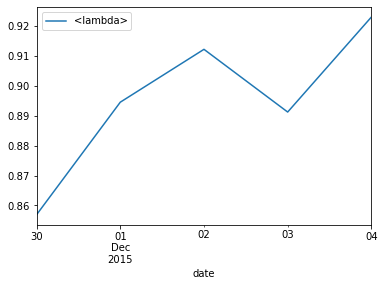

In [83]:
#绘制图，看看这些奇怪的结果是不断发生的，还是突然开始发生的。

import matplotlib.pyplot as plt

#对比实验组和控制组的每日转换率并画出

data_test_by_day = data.groupby("date")["conversion"].agg([lambda x: x[data["test"]==1].mean()/x[data["test"]==0].mean()]).plot()

plt.show()

#实验组一直比控制组差，并且在不同的日子里有相对较小的差异。这可能意味着我们有足够的数据，但在实验中存在一些偏差

  <font color=black size=4 face=雅黑>**检查测试组和控制组是否具有相同的分布** </font>

 检查ABtest是否有效随机化意味着确保所有变量在测试和控制中具有相同的分布。所以，以第一个变量source为例，这意味着要检查来自广告、SEO和direct的用户比例是否相同。

In [26]:
#let's group by source and estimate relative frequencies
data_grouped_source = data.groupby("source")["test"].agg([
lambda x: len(x[x==0]), 
lambda x: len(x[x==1])
              ])
    
#get relative frequencies
data_grouped_source

,<lambda_0>,<lambda_1>
source,,
Ads,74352,86448
Direct,37238,43047
SEO,73721,86279


In [27]:
data_grouped_source_rate=data_grouped_source/data_grouped_source.sum()

In [28]:
data_grouped_source_rate.rename(index=str, columns={'<lambda_0>': "frequency_test_0 ", "<lambda_1>": "frequency_test_1"})

,frequency_test_0,frequency_test_1
source,,
Ads,0.401228,0.400641
Direct,0.200949,0.199500
SEO,0.397823,0.399858


可以看出，不同来源的相对频率是相同的。也就是说，在实验组和控制组中，来自广告、直接和SEO的用户比例基本相同。

我们可以继续检查所有这样的变量。但这将非常耗时，特别是当开始考虑数值变量和具有多个层次的范畴变量时。

<mark>简单方法：<mark>

1. 现在去掉转换变量(coversion)，只是检查这两个组用户分布是否相同。


2. 使用test变量作为我们的标签。尝试建立一个模型，将test为0的用户和test为1的用户分开。如果ab测试随机化效果良好，这将是不可能的，因为两组完全相同。如果所有变量相对频率都相同，则没有模型能够将test==1与test==0分开。如果ab测试随机化效果不佳，该模型将设法使用一个给定的变量来分隔两组。


3. 选择一个决策树作为模型。可以清楚地看到哪个变量(如果有的话)被用于分割。这就是ab测试随机化分组失败的地方。

In [42]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
#将日期转换成string,这样容易把日期转换成哑变量
data['date'] = data['date'].apply(str)
  
data_dummy = pd.get_dummies(data)

#去除掉coversion数据，test现在是lable
train_cols = data_dummy.drop(['test', 'conversion'], axis=1)
  
tree=DecisionTreeClassifier(
    #改变权重。让我们的数据集完全平衡，它使树输出更容易理解
    class_weight="balanced",
    #只有在有价值的时候分割。默认值为0意味着无论如何都要分割，但这会产生大量嘈杂和无关的分割
    min_impurity_decrease = 0.001
    )

tree.fit(train_cols,data_dummy['test'])
  
    
export_graphviz(tree, out_file="tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_test.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_test.dot")
s.view()

'tree_test.dot.pdf'

所以我们可以看到，实验组和控制组分布是不一样的!来自Argentina和Uruguay的用户更有可能处于实验组。当country_Argentina为1时，树状图显示控制组的用户为~23%，实验组中为77%(87.3%*88.3%)。对于乌拉圭来说，这个比例更加极端:12.7%的控制组用户和87.3%的实验组用户!


In [32]:
#我们再反复检查一下。对照和测试中阿根廷和乌拉圭用户的比例。

data_dummy.groupby("test")[["country_Argentina", "country_Uruguay"]].mean()

,country_Argentina,country_Uruguay
test,,
0,0.050488,0.002239
1,0.173223,0.017236


我们生成的决策树是对的!在测试中，17%的用户来自阿根廷，但在对照组中，只有5%的用户来自阿根廷。乌拉圭的情况更为极端:test拥有1.7%的乌拉圭用户，control只有0.2%的乌拉圭用户。

这是一个大问题，因为这意味着我们在ab测试中转化率的差异很大程度上取决于两组用户的不同。

In [43]:
#验证

#使用原始数据集得到的测试结果
original_data = stats.ttest_ind(data_dummy[data['test'] == 1]['conversion'], 
                                data_dummy[data['test'] == 0]['conversion'], 
                                equal_var=False)
  
#使用去除了阿根廷和乌拉圭的数据集得到的测试结果
data_no_AR_UR = stats.ttest_ind(data_dummy[(data['test'] == 1) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                data_dummy[(data['test'] == 0) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                equal_var=False)
  
print(
pd.DataFrame({"data_type" : ["Full", "Removed_Argentina_Uruguay"], 
                  "p_value" : [original_data.pvalue, data_no_AR_UR.pvalue],
                  "t_statistic" : [original_data.statistic, data_no_AR_UR.statistic]
                 })
)

                   data_type       p_value  t_statistic
0                       Full  1.928918e-13    -7.353895
1  Removed_Argentina_Uruguay  7.200849e-01     0.358346


差异巨大! 检验中当某些国家的数量过多或过少会导致显著性。所以实验组比控制组更糟糕! 除去这两个国家后，我们得到了不具有显著的结果。

虽然我们的目标是提高转化率，所以这并不是一个很大的成功，但至少知道本地化的翻译不会使得转换率变得更差!

<font color=black size=4 face=雅黑>**项目建议**</font>


1. 与负责随机化的软件工程师交谈，找出哪里出了问题，修复它并重新运行测试。要注意，当发现一个bug时，这可能是一个迹象，可能有更多的东西出错了，而不仅仅是发现的那个。所以，当发现漏洞时，一定要找到问题的根源


2. 如果你确实发现其他一切都很好，但由于某些原因，只有这两个国家有问题，你可以调整这两个部分的权重，使相对频率变得相同，然后重新检查测试结果